Run this piece of code to get the necessary word embeddings txt used for the models.

In [1]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-01-04 12:24:24--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-04 12:24:24--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 40s  

2022-01-04 12:27:05 (5.13 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import *
import torch.nn as nn
import nltk
import random
import sys
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,RegexpTokenizer

In [3]:
def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

:This code block reads the vaccine data and cleans the datasets. It get's rid of punctuation and links. After that it open's the glove word embeddings and sets up a dictionary in which if you call emmbed_dict[word] it gives you the vector for that word. Tha vaccine data must be in a folder named 'data' and be uploaded in google collab or you can choose a different path. If you change the file name you can use another dataset for a testset.

In [4]:
#dataset and variables initialization
fields = ['tweet', 'label']
trainset = pd.read_csv("/content/data/vaccine_train_set.csv", usecols=fields)
testset = pd.read_csv("/content/data/vaccine_validation_set.csv", usecols=fields)
X_train = []
Y_train = []
X_train = trainset.tweet
Y_train = trainset.label
X_test = []
Y_test = []
X_test = testset.tweet
Y_test = testset.label

#nltk stopwords and punctuation datasets download
nltk.download('stopwords')
nltk.download('punkt')

#data cleaning
def clean_data(dataset):
    stop_words = set(stopwords.words('english'))
    #adding symbols we dont need in the stop words because the tokenizer tokenizes them alone anyway
    stop_words.add(":")
    stop_words.add("@")
    stop_words.add("#")
    stop_words.add(",")
    stop_words.add(".")
    stop_words.add("\'\'")
    new_dataset = []
    for row in dataset:
      dataset_tokens = word_tokenize(row)
      filtered = ""
      for w in dataset_tokens:
        #filtering stop_words and weird symbols (see above), removing the http word and removing links
        if (w not in stop_words) and ("http" not in w) and ("/" not in w ):
          filtered = filtered + " " + w
      new_dataset.append(filtered)
    return new_dataset
X_train = clean_data(X_train)
X_test = clean_data(X_test)
x = X_train
y= Y_train

#setup word embeddings dictionary with the words as keys
emmbed_dict = {}
with open('/content//glove.6B.300d.txt','r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


This cell makes the dataset using averaging on the word embeddings as in the previous project with feed-forward NN so every sentence has the same input length. Run this only if you want to test the RNN without using custom input length. If you want custom input and sequence length run the next cell.

In [ ]:
def words2vec(dataset):
    new_dataset = []
    for row in dataset:
      dataset_tokens = word_tokenize(row)
      vector = []
      #for each word dimension
      for i in range(len(emmbed_dict["word"])):
        sum = 0
        #calculate all sentence's words i'th dimension sum
        for w in dataset_tokens:
          if(w not in emmbed_dict):
            #lowercase the word because glove has every word in lowercase
            w = w.lower()
            #if a word does not exist in the word embeddings we continue to the next
            if(w not in emmbed_dict):
              continue
          sum = sum+emmbed_dict.get(w)[i]
        #append vector with their average
        vector.append(sum/len(dataset_tokens))
      new_dataset.append(vector)
    #the final value will be a [1][glove dimension] vector so all sentences of the dataset will have the same dimension
    return new_dataset
X_train_vec = words2vec(X_train)
X_test_vec = words2vec(X_test)

This cell finds the average sentence words from the dataset and makes a tensor using that as a sequence length. The input is still the embeddings dimension chosen above.

In [5]:
import math
def batch_avg_seq(batch):
  rows = 0
  sum = 0
  for row in batch:
      batch_tokens = word_tokenize(row)
      rows += 1
      for w in batch_tokens:
        sum += 1
  res = sum/rows
  if( (res*10)%10 > 5):
    return math.ceil(sum/rows)
  else:
    return int(sum/rows)

seq = batch_avg_seq(X_train)
#print(seq)
def sentence2vec(dataset):
    new_dataset = []
    for row in dataset:
      dataset_tokens = word_tokenize(row)
      i = 0
      vector = []
      embds = []
      for w in dataset_tokens:
        if(w not in emmbed_dict):
            #lowercase the word because glove has every word in lowercase
            w = w.lower()
            #if a word does not exist in the word embeddings we continue to the next
            if(w not in emmbed_dict):
              continue
        vector.append(emmbed_dict.get(w))
        i += 1
        if(i == seq):
          break
      if(i < seq):
        for k in range(i,seq):
          vector.append(np.zeros(300))
      new_dataset.append(vector)
    return torch.tensor(new_dataset, dtype=torch.float)
X_train_vec = sentence2vec(X_train)
X_test_vec = sentence2vec(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Making the tensors for the test set and the train set

In [6]:
x = X_train_vec.clone().detach()
x_test = X_test_vec.clone().detach()
y = torch.tensor(Y_train, dtype=torch.float)
yy_test = torch.tensor(Y_test, dtype=torch.float)
yy_test = yy_test.type(torch.LongTensor)
y = y.type(torch.LongTensor)
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: torch.Size([15976, 14, 300])
y shape: torch.Size([15976])


This function get's the X and Y of a dataset, a model and a loss function and calculates the model's accuracy score,f1,precision and loss for that dataset applied to the given model. The last returned argument is the model's predictions returned raw because it is used for plotting the ROC curves later. The for loop takes the class with the most score from the predictions and makes an array with them so we can calculate the scores easier by using two [n][1] arrays


In [7]:
def get_ScoreAndLoss(ts,y_testset,my_model,LossFunc):
  with torch.no_grad():
    my_model.eval()

    #predictions
    y_pred_t = my_model(ts)
    y_final = []

    #take the max of the 3 outputs and append y_final with the correct label (0,1,2) 
    #which will be compared with the real labels to calculate score
    for i in range(len(y_pred_t)):
      if(max(y_pred_t[i]) == y_pred_t[i][0]):
        y_final.append(0)
      elif(max(y_pred_t[i]) == y_pred_t[i][1]):
        y_final.append(1)
      else:
        y_final.append(2)
    
    #calculate scores
    confm=confusion_matrix(y_testset, y_final)
    score = ((int)(confm[0][0] + confm[1][1] +confm[2][2])/len(y_testset))
    f1 = f1_score(y_testset, y_final, average='weighted')
    rec = recall_score(y_testset, y_final, average='weighted')
    prec = precision_score(y_testset, y_final, average='weighted',zero_division=0)

    #calculate loss
    y_testset_tensor = y_testset.clone().detach()
    y_testset_tensor = y_testset_tensor.type(torch.LongTensor)
    loss = LossFunc(y_pred_t,y_testset_tensor)
  return score,loss.item(),f1,rec,prec,y_pred_t

This is the bidirectional stacked RNN. You can tune in the green area all the hyperparameters for each cell which are number of stacked layers, number of hidden layers, gradient clipping, dropout propability, learning rate, batch size and number of epochs.

In [8]:
from numpy.ma.core import append
class BiRNN(nn.Module):

    cells = {
        "LSTM"    : nn.LSTM,
        "GRU"     : nn.GRU
    }
    
    def __init__(self, num_features, num_hidden, num_classes, layers, drop_prob, cell_type='LSTM'):
        super().__init__()
        self.cell_type = cell_type
        self.num_layers = layers
        self.hidden_size = num_hidden
        # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        self.cell = BiRNN.cells[cell_type](input_size = num_features, 
                                         hidden_size = num_hidden, 
                                         num_layers = layers,
                                         batch_first=True,
                                         dropout = drop_prob,
                                         bidirectional = True)
        self.linear = nn.Linear(num_hidden*2, num_classes)
        self.drop = nn.Dropout(p = drop_prob)
                
    def forward(self, X):
      if self.cell_type == 'LSTM':
        h0 = torch.zeros(self.num_layers*2, len(X), self.hidden_size)
        c0 = torch.zeros(self.num_layers*2, len(X), self.hidden_size)

        out, _ = self.cell(X, (h0,c0)) 

        out = out[:, -1, :]
        out = self.linear(out)   
        return out

      if self.cell_type == 'GRU':
        h0 = torch.zeros(self.num_layers*2, len(X), self.hidden_size)
        
        out, _ = self.cell(X, h0) 
        out = out[:, -1, :]
        out = self.linear(out)   
        return out

seq_length = seq
dim = 300

#--------------LSTM HYPERPARAMETERS---------------
lay = 3
num_hid = 50
grad_clip = 4
dropout_prob = 0.25
LR = 0.0008
batch = 400
N_EPOCHS = 5
#-------------------------------------------------

net = BiRNN(num_features=dim, num_hidden=num_hid, num_classes=3, layers = lay, drop_prob = dropout_prob, cell_type='LSTM')
optimizer = torch.optim.Adam(net.parameters(), lr=LR)

#--------------GRU HYPERPARAMETERS---------------
lay = 4
num_hid = 30
grad_clip = 4
dropout_prob = 0.3
LR = 0.001
batch = 300
N_EPOCHS = 5
#------------------------------------------------

gru_net = BiRNN(num_features=dim, num_hidden=num_hid, num_classes=3, layers = lay, drop_prob = dropout_prob, cell_type='GRU')
optimizer_gru = torch.optim.Adam(gru_net.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

#Initialize dataloader
dataset = torch.utils.data.TensorDataset(x, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch, shuffle=True)

LSTM-BiRNN model training.

In [9]:
losses = []
scores_epoch_avg = []
train_losses_per_epoch = []
test_losses = []
test_scores = []
roc_scores = []

for epoch_i in range(N_EPOCHS):
    # Ensure net in training mode
    net.train()
    batch_losses = []
    for x_batch, y_batch in dataloader:
      # Get net output, calculate loss, and generate gradients
      output = net(x_batch)

      scores = []
      y_train_final_pred = []
      #This for loop is the same as in the 'get_ScoreAndLoss' function presented above
      for i in range(len(output)):
        if(max(output[i]) == output[i][0]):
          y_train_final_pred.append(0)
        elif(max(output[i]) == output[i][1]):
          y_train_final_pred.append(1)
        else:
          y_train_final_pred.append(2)

      loss = criterion(output, y_batch)
      batch_losses.append(loss.item())

      # Zero out gradients
      optimizer.zero_grad()
      # Generate gradients via autodiff
      loss.backward() 
      
      # Clip params
      for param in net.parameters():
          if param.grad is None:
              continue
          grad_val = torch.clamp(param.grad, -grad_clip, grad_clip)
      optimizer.step()

      scores.append(f1_score(y_batch, y_train_final_pred, average='weighted'))

      # Track loss
      losses.append(loss.item())
    
    scores_epoch_avg.append(sum(scores)/len(scores))
    train_losses_per_epoch.append(sum(batch_losses)/len(dataloader))
    _ , test_loss, test_score , _ , _ , roc_score= get_ScoreAndLoss(x_test,yy_test,net,criterion)
    test_scores.append(test_score)
    test_losses.append(test_loss)
    roc_scores.append(roc_score)

    str_ = f'\rEpoch {epoch_i+1}/{N_EPOCHS} -- Train Loss: {sum(batch_losses)/len(dataloader):.5f} -- Testset f1 Score: {test_score}'
    print(str_)

Epoch 1/5 -- Train Loss: 0.96636 -- Testset f1 Score: 0.568501843374826
Epoch 2/5 -- Train Loss: 0.80003 -- Testset f1 Score: 0.6108677664061907
Epoch 3/5 -- Train Loss: 0.73123 -- Testset f1 Score: 0.6517471457795513
Epoch 4/5 -- Train Loss: 0.68605 -- Testset f1 Score: 0.6872712561032217
Epoch 5/5 -- Train Loss: 0.65916 -- Testset f1 Score: 0.6935884450382923


GRU-BiRNN model training.

In [10]:
#Train the GRU model with in the same way
losses_gru = []
scores_epoch_avg_gru = []
train_losses_per_epoch_gru = []
test_losses_gru = []
test_scores_gru = []
roc_scores_gru = []

for epoch_i in range(N_EPOCHS):
    gru_net.train()
    batch_losses = []
    for x_batch, y_batch in dataloader:
      output = gru_net(x_batch)

      scores = []
      y_train_final_pred = []
      for i in range(len(output)):
        if(max(output[i]) == output[i][0]):
          y_train_final_pred.append(0)
        elif(max(output[i]) == output[i][1]):
          y_train_final_pred.append(1)
        else:
          y_train_final_pred.append(2)

      loss = criterion(output, y_batch)
      batch_losses.append(loss.item())

      optimizer_gru.zero_grad()
      loss.backward() 
      
      for param in gru_net.parameters():
          if param.grad is None:
              continue
          grad_val = torch.clamp(param.grad, -grad_clip, grad_clip)
      optimizer_gru.step()

      scores.append(f1_score(y_batch, y_train_final_pred, average='weighted'))

      losses_gru.append(loss.item())
    
    scores_epoch_avg_gru.append(sum(scores)/len(scores))
    train_losses_per_epoch_gru.append(sum(batch_losses)/len(dataloader))
    _ , test_loss, test_score , _ , _ , roc_score= get_ScoreAndLoss(x_test,yy_test,gru_net,criterion)
    test_scores_gru.append(test_score)
    test_losses_gru.append(test_loss)
    roc_scores_gru.append(roc_score)

    str_ = f'\rEpoch {epoch_i+1}/{N_EPOCHS} -- Train Loss: {sum(batch_losses)/len(dataloader):.5f} -- Testset f1 Score: {test_score}'
    print(str_)

Epoch 1/5 -- Train Loss: 0.91066 -- Testset f1 Score: 0.6041938140041511
Epoch 2/5 -- Train Loss: 0.76046 -- Testset f1 Score: 0.6550402932593451
Epoch 3/5 -- Train Loss: 0.71334 -- Testset f1 Score: 0.6678310783957868
Epoch 4/5 -- Train Loss: 0.67986 -- Testset f1 Score: 0.6839966815204818
Epoch 5/5 -- Train Loss: 0.65886 -- Testset f1 Score: 0.6960095117839762


This cell calculates scores on the validation set after both trainings and prints them so we can see their final performance.

In [11]:
  print("LSTM Model scores:")
  sc , los, f1, rec, prec, _ = get_ScoreAndLoss(x_test, yy_test, net, criterion)
  print("Test Accuracy Score: ", end = '')
  print(sc*100)
  print("Test F1 Score: ", end = '')
  print(f1*100)
  print("Test Recall Score: ", end = '')
  print(rec*100)
  print("Test Precision Score: ", end = '')
  print(prec*100)
  print("Test Loss: ", end = '')
  print(los)
  print("\n--------------------------------------------------------------------\n")
  print("GRU Model scores:")
  sc , los, f1, rec, prec, _ = get_ScoreAndLoss(x_test, yy_test, gru_net, criterion)
  print("Test Accuracy Score: ", end = '')
  print(sc*100)
  print("Test F1 Score: ", end = '')
  print(f1*100)
  print("Test Recall Score: ", end = '')
  print(rec*100)
  print("Test Precision Score: ", end = '')
  print(prec*100)
  print("Test Loss: ", end = '')
  print(los)

LSTM Model scores:
Test Accuracy Score: 69.98247151621385
Test F1 Score: 69.35884450382923
Test Recall Score: 69.98247151621385
Test Precision Score: 69.46419621912841
Test Loss: 0.7024078369140625

--------------------------------------------------------------------

GRU Model scores:
Test Accuracy Score: 70.37686240140228
Test F1 Score: 69.60095117839762
Test Recall Score: 70.37686240140228
Test Precision Score: 70.57112357210559
Test Loss: 0.6996752023696899


This function plots the learning curves which are f1_score per epoch and loss per epoch in our situation. It takes the losses,scores etc. ready to go and just makes the plotting.

In [12]:
#plot curves
def plot_learning_curves(train_losses, train_scores, test_losses, test_scores, axes, ylim_score, ylim_loss, title):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_ylim(*ylim_score)
    axes[1].set_ylim(*ylim_loss)
    
    axes[0].set_xlabel("Epochs")
    axes[1].set_xlabel("Epochs")
    axes[0].set_ylabel("f1 Score")
    axes[1].set_ylabel("Losses")

    axes[0].set_title(title + " Score per Epoch")
    axes[0].grid()
    axes[0].plot(
        train_scores, "o-", color="orange", label="Train"
    )
    axes[0].plot(
        test_scores, "o-", color="blue", label="Valid"
    )

    axes[1].set_title(title + " Losses per epoch")
    axes[1].grid()
    axes[1].plot(
        train_losses, "o-", color="orange", label="Train"
    )
    axes[1].plot(
        test_losses, "o-", color="blue", label="Valid"
    )
    axes[0].legend(loc="best")
    axes[1].legend(loc="best")
    return plt

This cell makes the curves for the LSTM net by calling the above function.

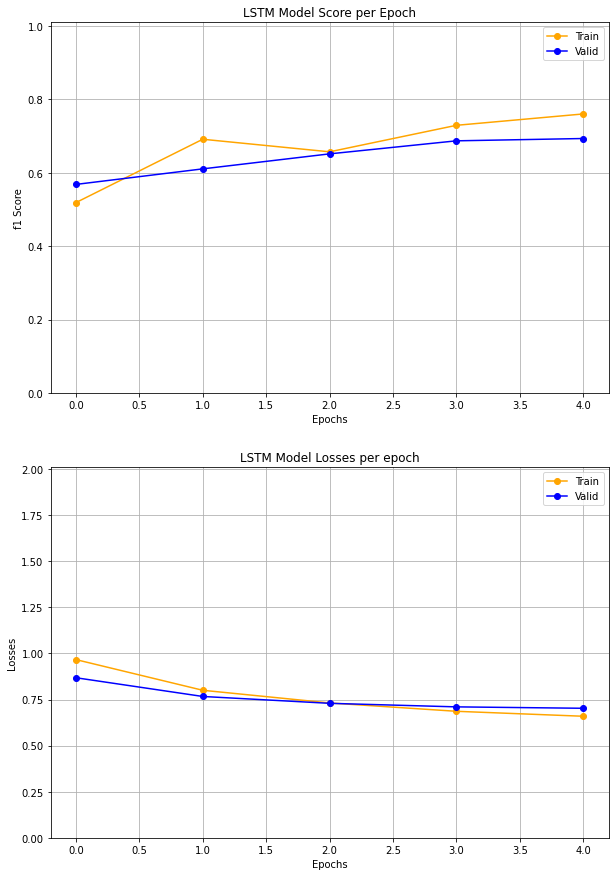

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

plot_learning_curves(
    train_losses_per_epoch, scores_epoch_avg, test_losses, test_scores, axes=axes, ylim_score=(0, 1.01), ylim_loss=(0,2.01), title = "LSTM Model"
)
plt.show()

This cell makes the curves for the GRU net.

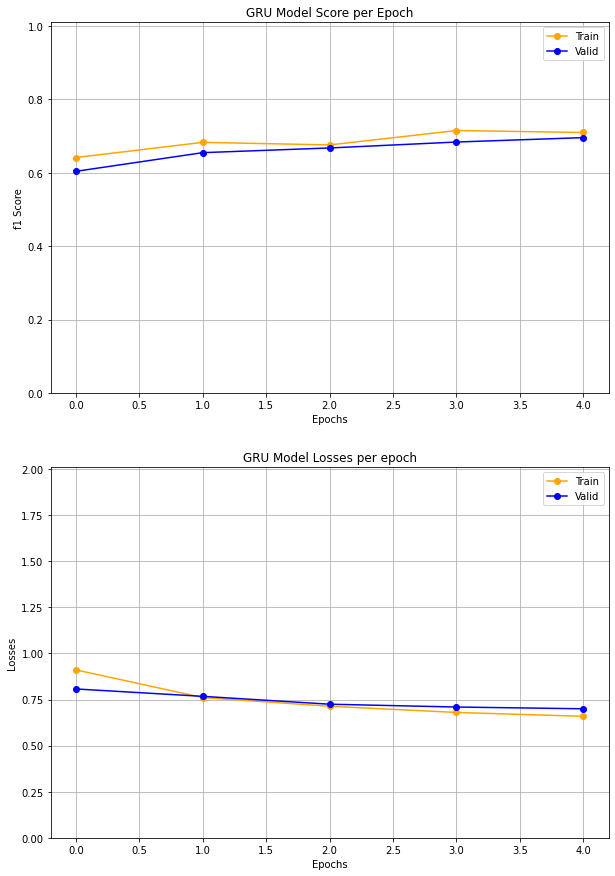

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

plot_learning_curves(
    train_losses_per_epoch_gru, scores_epoch_avg_gru, test_losses_gru, test_scores_gru, axes=axes, ylim_score=(0, 1.01), ylim_loss=(0,2.01), title = "GRU Model"
)
plt.show()

This is the same function that scikit learn has for plotting the ROC curves with the only difference that I give the y_test and y_score arrays already calculated so I removed the piece of code that trains a model. The y_test gets binarized because we have 3 classes and it needs to be like that for the ROC curves to be plotted. The y_score is an array [n][samples][3] where the samples are the validation set's sentences, n is the number of epochs and 3 are the propabilities of each sentence to belong to a specific class (0, 1, 2). 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plt_roc(y_t, y_s, title):
  y_test = y_t
  y_score = y_s
  #binarize testset labels because it is needed for multilabel classficiation ROC
  y_test = label_binarize(y_test, classes=[0, 1, 2])
  n_classes = y_test.shape[1]
  #Get the computed predicted scores on the test set of the last epoch
  y_score = y_s[len(y_s)-1]

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Plot of a ROC curve for a specific class
  plt.figure()
  plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title + " ROC Curve")
  plt.legend(loc="lower right")
  plt.show()

  # Plot ROC curve
  plt.figure()
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]))
  for i in range(n_classes):
      plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                    ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.show()

Run this code cell to generate ROC curves for the LSTM-RNN net.

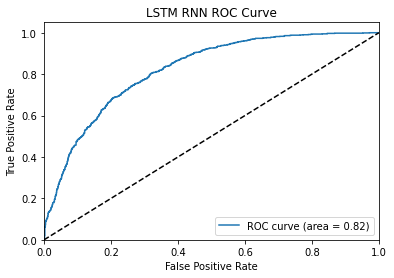

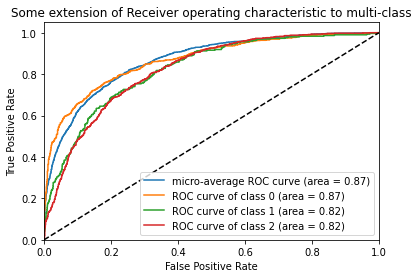

In [16]:
#Plot roc for the LSTM RNN
plt_roc(yy_test, roc_scores, "LSTM RNN")

Run this code cell to generate ROC curves for the LSTM-RNN net.

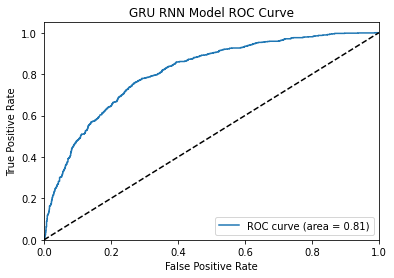

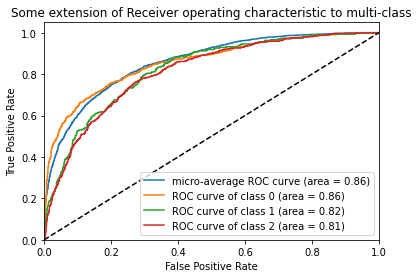

In [17]:
#Plot roc for the GRU RNN
plt_roc(yy_test, roc_scores_gru, "GRU RNN Model")